In [1]:
import tensorflow as tf
import numpy as np
import os
from keras.layers import Conv2D, Activation, AveragePooling2D, MaxPooling2D, ZeroPadding2D, Input, concatenate
from keras.layers.core import Lambda, Dense, Flatten
from numpy import genfromtxt
import cv2
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras import layers
from keras import backend as K
from keras.layers import *
from keras.models import Model
from tensorflow.keras.applications import inception_v3
from tensorflow.keras.applications.inception_v3 import InceptionV3
from sklearn.preprocessing import normalize
import random
import matplotlib.pyplot as plt
import keras
from keras.utils import plot_model
import sys
K.set_image_data_format('channels_first')

In [4]:
import cv2
from pygrabber.dshow_graph import FilterGraph

graph = FilterGraph()

print(graph.get_input_devices())# list of camera device

device =graph.get_input_devices().index("Logi Capture")

cap = cv2.VideoCapture(device)

while cap.isOpened():
    ret, frame = cap.read()

    if not ret:
        break

    cv2.imshow('Facetracker', frame)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()

['c922 Pro Stream Webcam', 'Integrated Camera', 'OBS-Camera', 'Logi Capture', 'OBS Virtual Camera']


In [2]:
import tensorflow as tf
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        # Restrict TensorFlow to allocate a fraction of GPU memory
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        print(e)

1 Physical GPUs, 1 Logical GPUs


In [3]:
# Anchor images as empty list
passport = []
selfie = []
employee_num = 0
PATH = 'data/trainset/'

In [4]:
for folder in os.listdir(PATH):
    for subfolder in os.listdir(os.path.join(PATH, folder)):
        employee_num += 1
        for image in os.listdir(os.path.join(PATH, folder, subfolder)):
            if 'script' in image:
                passport.append(image)
            else:
                selfie.append(image)

In [5]:
print(employee_num)
print(len(passport))
print (len(selfie))

1012
1221
3198


In [71]:
#print(passport)
image = cv2.imread(os.path.join(PATH,'0001','0001_0000255','0001_0000255_script.jpg'))

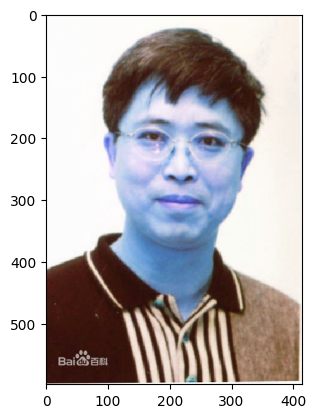

In [72]:
plt.imshow(image)
plt.show()

In [40]:
from PIL import Image
img = Image.open('pictures/model-details.jpg')
img.show()

# Model Architecture

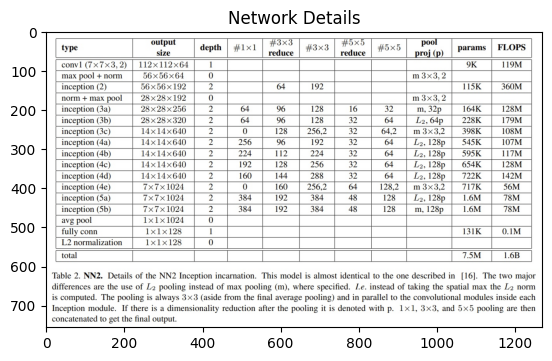

In [39]:
from matplotlib import pyplot as plt
from matplotlib import image as mpimg

plt.title("Network Details")
image = mpimg.imread('pictures/model-details.jpg')
plt.imshow(image)
plt.show()

## Defining Inception Blocks

In [2]:
# Inception(2)

def inception_2(X):
    # 3x3 Conv
    X_3 = Conv2D(filters=64,kernel_size=(1,1),strides=(1,1),padding = 'same', data_format='channels_first', name='inception_2_conv1')(X)
    X_3 = BatchNormalization(axis=1,epsilon=1e-5,name='inception_2_bnorm1')(X_3)
    X_3 = Activation('relu')(X_3)
    X_3 = Conv2D(filters=192,kernel_size=(3,3),strides=(1,1),padding = 'same', data_format='channels_first', name='inception_2_conv2')(X_3)
    X_3 = BatchNormalization(axis=1,epsilon=1e-5,name='inception_2_bnorm2')(X_3)
    X_3 = Activation('relu')(X_3)

    return X_3

In [3]:
# Inception (3a)

def inception_3a(X):
    # 1x1 Conv
    X_1 = Conv2D(filters=64, kernel_size=(1,1),strides=(1,1),padding='same', data_format='channels_first', name='inception_3a_conv1')(X)
    X_1 = BatchNormalization(axis=1, epsilon=1e-5,name='inception_3a_bnorm1')(X_1)
    X_1 = Activation('relu')(X_1)

    # 3x3 Conv
    X_3 = Conv2D(filters=96, kernel_size=(1,1), strides=(1,1), padding='same', data_format='channels_first', name='inception_3a_conv2')(X)
    X_3 = BatchNormalization(axis=1, epsilon=1e-5, name='inception_3a_bnorm2')(X_3)
    X_3 = Activation('relu')(X_3)
    X_3 = Conv2D(filters=128, kernel_size=(3,3), strides=(1,1), padding='same', data_format='channels_first', name='inception_3a_conv3')(X_3)
    X_3 = BatchNormalization(axis=1, epsilon=1e-5, name='inception_3a_bnorm3')(X_3)
    X_3 = Activation('relu')(X_3)

    # 5x5 Conv
    X_5 = Conv2D(filters=16, kernel_size=(1,1), strides=(1,1), padding='same', data_format='channels_first', name='inception_3a_conv4')(X)
    X_5 = BatchNormalization(axis=1, epsilon=1e-5, name='inception_3a_bnorm4')(X_5)
    X_5 = Activation('relu')(X_5)
    X_5 = Conv2D(filters=32, kernel_size=(5,5),strides=(1,1), padding='same', data_format='channels_first', name='inception_3a_conv5')(X_5)
    X_5 = BatchNormalization(axis=1, epsilon=1e-5, name='inception_3a_bnorm5')(X_5)
    X_5 = Activation('relu')(X_5)

    # 32 MaxPooling
    X_P = MaxPooling2D(pool_size=(1,1), strides=(1,1), padding='same', data_format='channels_first')(X)
    X_P = Conv2D(filters=32, kernel_size=(1,1),strides=(1,1),padding='same',data_format='channels_first',name='inception_3a_conv6')(X_P)
    X_P = BatchNormalization(axis=1, epsilon=1e-5,name='inception_3a_bnorm6')(X_P)
    X_P = Activation('relu')(X_P)

    # Concatenate
    inception = concatenate([X_1,X_3,X_5,X_P], axis=1)
    return inception

In [4]:
# Inception (3b)

def inception_3b(X):
    # 1x1 Conv
    X_1 = Conv2D(filters=64, kernel_size=(1,1), strides=(1,1), padding='same', data_format='channels_first', name='inception_3b_conv1')(X)
    X_1 = BatchNormalization(axis=1, epsilon=1e-5, name='inception_3b_bnorm1')(X_1)
    X_1 = Activation('relu')(X_1)

    # 3x3 Conv
    X_3 = Conv2D(filters=96, kernel_size=(1,1), strides=(1,1), padding='same', data_format='channels_first', name='inception_3b_conv2')(X)
    X_3 = BatchNormalization(axis=1, epsilon=1e-5, name='inception_3b_bnorm2')(X_3)
    X_3 = Activation('relu')(X_3)
    X_3 = Conv2D(filters = 128, kernel_size=(3,3), strides=(1,1), padding='same', data_format='channels_first', name='inception_3b_conv3')(X_3)
    X_3 = BatchNormalization(axis=1, epsilon=1e-5, name='inception_3b_bnorm3')(X_3)
    X_3 = Activation('relu')(X_3)

    # 5x5 Conv
    X_5 = Conv2D(filters=32, kernel_size=(1,1), strides=(1,1), padding='same', data_format='channels_first', name='inception_3b_conv4')(X)
    X_5 = BatchNormalization(axis=1, epsilon=1e-5, name='inception_3b_bnorm4')(X_5)
    X_5 = Activation('relu')(X_5)
    X_5 = Conv2D(filters = 64, kernel_size=(5,5), strides=(1,1), padding='same', data_format='channels_first', name='inception_3b_conv5')(X_5)
    X_5 = BatchNormalization(axis=1, epsilon=1e-5, name='inception_3b_bnorm5')(X_5)
    X_5 = Activation('relu')(X_5)

    # L2 Pooling
    X_P = Lambda(lambda x:K.l2_normalize(x,axis=1),name='lambda_1')(X)
    X_P = Conv2D(filters = 64, kernel_size=(1,1), strides=(1,1), data_format='channels_first', name='inception_3b_conv6')(X_P)
    X_P = BatchNormalization(axis=1, epsilon=1e-4,name='inception_3b_bnorm6')(X_P)
    X_P = Activation('relu')(X_P)

    inception = concatenate([X_1, X_3, X_5, X_P], axis=1)
    return inception

In [5]:
# Inception (3c)

def inception_3c(X):
    # 3x3 Conv
    X_3 = Conv2D(128,(1,1),(1,1),padding='same',data_format='channels_first',name='inception_3c_conv1')(X)
    X_3 = BatchNormalization(1,epsilon=1e-5,name='inception_3c_bnorm1')(X_3)
    X_3 = Activation('relu')(X_3)
    X_3 = Conv2D(256,(3,3),(2,2),padding='same',data_format='channels_first',name='inception_3c_conv2')(X_3)
    X_3 = BatchNormalization(1,epsilon=1e-5,name='inception_3c_bnorm2')(X_3)
    X_3 = Activation('relu')(X_3)

    # 5x5 Conv
    X_5 = Conv2D(32,(1,1),(1,1),padding='same',data_format='channels_first',name='inception_3c_conv3')(X)
    X_5 = BatchNormalization(1,epsilon=1e-5)(X_5)
    X_5 = Activation('relu')(X_5)
    X_5 = Conv2D(64,(5,5),(2,2),padding='same',data_format='channels_first',name='inception_3c_conv4')(X_5)
    X_5 = BatchNormalization(1,epsilon=1e-5)(X_5)
    X_5 = Activation('relu')(X_5)

    # 3x3 Max Pooling
    X_P = MaxPooling2D((3,3),(2,2),padding='same',data_format='channels_first')(X)
    X_P = BatchNormalization(1, epsilon=1e-5)(X_P)
    X_P = Activation('relu')(X_P)

    inception = concatenate([X_3, X_5, X_P], axis=1)
    return inception

In [6]:
# Inception (4a)

def inception_4a(X):
    # 1v1 Conv
    X_1 = Conv2D(filters=256, kernel_size=(1,1), strides=(1,1), padding='same', data_format='channels_first', name='inception_4a_conv1')(X)
    X_1 = BatchNormalization(axis=1, epsilon=1e-5, name='inception_4a_bnorm1')(X_1)
    X_1 = Activation('relu')(X_1)

    # 3x3 Conv
    X_3 = Conv2D(filters=96, kernel_size=(1,1), strides=(1,1), padding='same', data_format='channels_first', name='inception_4a_conv2')(X)
    X_3 = BatchNormalization(axis=1, epsilon=1e-5, name='inception_4a_bnorm2')(X_3)
    X_3 = Activation('relu')(X_3)
    X_3 = Conv2D(filters = 192, kernel_size=(3,3), strides=(1,1), padding='same', data_format='channels_first', name='inception_4a_conv3')(X_3)
    X_3 = BatchNormalization(axis=1, epsilon=1e-5, name='inception_4a_bnorm3')(X_3)
    X_3 = Activation('relu')(X_3)

    # 5x5 Conv
    X_5 = Conv2D(filters=32, kernel_size=(1,1), strides=(1,1), padding='same', data_format='channels_first', name='inception_4a_conv4')(X)
    X_5 = BatchNormalization(axis=1, epsilon=1e-5, name='inception_4a_bnorm4')(X_5)
    X_5 = Activation('relu')(X_5)
    X_5 = Conv2D(filters = 64, kernel_size=(5,5), strides=(1,1), padding='same', data_format='channels_first', name='inception_4a_conv5')(X_5)
    X_5 = BatchNormalization(axis=1, epsilon=1e-5, name='inception_4a_bnorm5')(X_5)
    X_5 = Activation('relu')(X_5)

    # L2 Pooling
    X_P = Lambda(lambda x:K.l2_normalize(x,axis=1),name='lambda_2')(X)
    X_P = Conv2D(filters = 128, kernel_size=(1,1), strides=(1,1), data_format='channels_first', name='inception_4a_conv6')(X_P)
    X_P = BatchNormalization(axis=1, epsilon=1e-5,name='inception_4a_bnorm6')(X_P)
    X_P = Activation('relu')(X_P)

    inception = concatenate([X_1, X_3, X_5, X_P], axis=1)
    return inception

In [7]:
# Inception (4b)

def inception_4b(X):
    # 1v1 Conv
    X_1 = Conv2D(filters=256, kernel_size=(1,1), strides=(1,1),padding='same', data_format='channels_first', name='inception_4b_conv1')(X)
    X_1 = BatchNormalization(axis=1, epsilon=1e-4, name='inception_4b_bnorm1')(X_1)
    X_1 = Activation('relu')(X_1)

    # 3x3 Conv
    X_3 = Conv2D(filters=96, kernel_size=(1,1), strides=(1,1), padding='same', data_format='channels_first', name='inception_4b_conv2')(X)
    X_3 = BatchNormalization(axis=1, epsilon=1e-5, name='inception_4b_bnorm2')(X_3)
    X_3 = Activation('relu')(X_3)
    X_3 = Conv2D(filters = 192, kernel_size=(3,3), strides=(1,1), padding='same', data_format='channels_first', name='inception_4b_conv3')(X_3)
    X_3 = BatchNormalization(axis=1, epsilon=1e-5, name='inception_4b_bnorm3')(X_3)
    X_3 = Activation('relu')(X_3)

    # 5x5 Conv
    X_5 = Conv2D(filters=32, kernel_size=(1,1), strides=(1,1), padding='same', data_format='channels_first', name='inception_4b_conv4')(X)
    X_5 = BatchNormalization(axis=1, epsilon=1e-5, name='inception_4b_bnorm4')(X_5)
    X_5 = Activation('relu')(X_5)
    X_5 = Conv2D(filters = 64, kernel_size=(5,5), strides=(1,1), padding='same', data_format='channels_first', name='inception_4b_conv5')(X_5)
    X_5 = BatchNormalization(axis=1, epsilon=1e-5, name='inception_4b_bnorm5')(X_5)
    X_5 = Activation('relu')(X_5)

    # L2 Pooling
    X_P = Lambda(lambda x:K.l2_normalize(x,axis=1),name='lambda_3')(X)
    X_P = Conv2D(filters = 128, kernel_size=(1,1), strides=(1,1), data_format='channels_first', name='inception_4b_conv6')(X_P)
    X_P = BatchNormalization(axis=1, epsilon=1e-5,name='inception_4b_bnorm6')(X_P)
    X_P = Activation('relu')(X_P)

    inception = concatenate([X_1, X_3, X_5, X_P], axis=1)
    return inception

In [8]:
# Inception (4c)

def inception_4c(X):
    # 1v1 Conv
    X_1 = Conv2D(filters=192, kernel_size=(1,1), strides=(1,1),padding='same', data_format='channels_first', name='inception_4c_conv1')(X)
    X_1 = BatchNormalization(axis=1, epsilon=1e-5, name='inception_4c_bnorm1')(X_1)
    X_1 = Activation('relu')(X_1)

    # 3x3 Conv
    X_3 = Conv2D(filters=128, kernel_size=(1,1), strides=(1,1), padding='same', data_format='channels_first', name='inception_4c_conv2')(X)
    X_3 = BatchNormalization(axis=1, epsilon=1e-5, name='inception_4c_bnorm2')(X_3)
    X_3 = Activation('relu')(X_3)
    X_3 = Conv2D(filters = 256, kernel_size=(3,3), strides=(1,1), padding='same', data_format='channels_first', name='inception_4c_conv3')(X_3)
    X_3 = BatchNormalization(axis=1, epsilon=1e-5, name='inception_4c_bnorm3')(X_3)
    X_3 = Activation('relu')(X_3)

    # 5x5 Conv
    X_5 = Conv2D(filters=32, kernel_size=(1,1), strides=(1,1),padding='same', data_format='channels_first', name='inception_4c_conv4')(X)
    X_5 = BatchNormalization(axis=1, epsilon=1e-5, name='inception_4c_bnorm4')(X_5)
    X_5 = Activation('relu')(X_5)
    X_5 = Conv2D(filters = 64, kernel_size=(5,5), strides=(1,1),padding='same', data_format='channels_first', name='inception_4c_conv5')(X_5)
    X_5 = BatchNormalization(axis=1, epsilon=1e-5, name='inception_4c_bnorm5')(X_5)
    X_5 = Activation('relu')(X_5)

    # L2 Pooling
    X_P = Lambda(lambda x:K.l2_normalize(x,axis=1),name='lambda_4')(X)
    X_P = Conv2D(filters = 128, kernel_size=(1,1), strides=(1,1), data_format='channels_first', name='inception_4c_conv6')(X_P)
    X_P = BatchNormalization(axis=1, epsilon=1e-5,name='inception_4c_bnorm6')(X_P)
    X_P = Activation('relu')(X_P)

    inception = concatenate([X_1, X_3, X_5, X_P], axis=1)
    return inception

In [9]:
# Inception (4d)

def inception_4d(X):
    # 1v1 Conv
    X_1 = Conv2D(filters=160, kernel_size=(1,1), strides=(1,1),padding='same', data_format='channels_first', name='inception_4d_conv1')(X)
    X_1 = BatchNormalization(axis=1, epsilon=1e-4, name='inception_4d_bnorm1')(X_1)
    X_1 = Activation('relu')(X_1)

    # 3x3 Conv
    X_3 = Conv2D(filters=144, kernel_size=(1,1), strides=(1,1), padding='same', data_format='channels_first', name='inception_4d_conv2')(X)
    X_3 = BatchNormalization(axis=1, epsilon=1e-4, name='inception_4d_bnorm2')(X_3)
    X_3 = Activation('relu')(X_3)
    X_3 = Conv2D(filters = 288, kernel_size=(3,3), strides=(1,1), padding='same', data_format='channels_first', name='inception_4d_conv3')(X_3)
    X_3 = BatchNormalization(axis=1, epsilon=1e-4, name='inception_4d_bnorm3')(X_3)
    X_3 = Activation('relu')(X_3)

    # 5x5 Conv
    X_5 = Conv2D(filters=32, kernel_size=(1,1), strides=(1,1),padding='same', data_format='channels_first', name='inception_4d_conv4')(X)
    X_5 = BatchNormalization(axis=1, epsilon=1e-4, name='inception_4d_bnorm4')(X_5)
    X_5 = Activation('relu')(X_5)
    X_5 = Conv2D(filters = 64, kernel_size=(5,5), strides=(1,1),padding='same', data_format='channels_first', name='inception_4d_conv5')(X_5)
    X_5 = BatchNormalization(axis=1, epsilon=1e-4, name='inception_4d_bnorm5')(X_5)
    X_5 = Activation('relu')(X_5)

    # L2 Pooling
    X_P = AveragePooling2D(pool_size=(3,3),strides=(3,3),data_format='channels_first')(X)
    X_P = Conv2D(filters = 128, kernel_size=(1,1), strides=(1,1), data_format='channels_first', name='inception_4d_conv6')(X_P)
    X_P = BatchNormalization(axis=1, epsilon=1e-4,name='inception_4d_bnorm6')(X_P)
    X_P = Activation('relu')(X_P)
    X_P = ZeroPadding2D(padding=(2,2), data_format='channels_first')(X_P)

    inception = concatenate([X_1, X_3, X_5, X_P], axis=1)
    return inception

In [10]:
# Inception (4e)

def inception_4e(X):
    # 3x3 Conv
    X_3 = Conv2D(filters=160, kernel_size=(1,1), strides=(1,1), padding='same', data_format='channels_first', name='inception_4e_conv2')(X)
    X_3 = BatchNormalization(axis=1, epsilon=1e-5, name='inception_4e_bnorm2')(X_3)
    X_3 = Activation('relu')(X_3)
    X_3 = Conv2D(filters = 256, kernel_size=(3,3), strides=(2,2), padding='same', data_format='channels_first', name='inception_4e_conv3')(X_3)
    X_3 = BatchNormalization(axis=1, epsilon=1e-5, name='inception_4e_bnorm3')(X_3)
    X_3 = Activation('relu')(X_3)

    # 5x5 Conv
    X_5 = Conv2D(filters=64, kernel_size=(1,1), strides=(1,1), padding = 'same', data_format='channels_first', name='inception_4e_conv4')(X)
    X_5 = BatchNormalization(axis=1, epsilon=1e-5, name='inception_4e_bnorm4')(X_5)
    X_5 = Activation('relu')(X_5)
    X_5 = Conv2D(filters = 128, kernel_size=(5,5), strides=(2,2), padding = 'same', data_format='channels_first', name='inception_4e_conv5')(X_5)
    X_5 = BatchNormalization(axis=1, epsilon=1e-5, name='inception_4e_bnorm5')(X_5)
    X_5 = Activation('relu')(X_5)

    # Max Pooling
    X_P = MaxPooling2D((3,3),(2,2), padding='same', data_format='channels_first')(X)
    X_P = Conv2D(filters = 128, kernel_size=(1,1), strides=(1,1), padding='same', data_format='channels_first', name='inception_4e_conv6')(X_P)
    X_P = BatchNormalization(axis=1, epsilon=1e-5,name='inception_4e_bnorm6')(X_P)
    X_P = Activation('relu')(X_P)

    inception = concatenate([X_3, X_5, X_P], axis=1)
    return inception

In [11]:
# Inception (5a)

def inception_5a(X):
    # 1v1 Conv
    X_1 = Conv2D(filters=256, kernel_size=(1,1), strides=(1,1), data_format='channels_first', name='inception_5a_conv1')(X)
    X_1 = BatchNormalization(axis=1, epsilon=1e-5, name='inception_5a_bnorm1')(X_1)
    X_1 = Activation('relu')(X_1)

    # 3x3 Conv
    X_3 = Conv2D(filters=96, kernel_size=(1,1), strides=(1,1), padding='same', data_format='channels_first', name='inception_5a_conv2')(X)
    X_3 = BatchNormalization(axis=1, epsilon=1e-5, name='inception_5a_bnorm2')(X_3)
    X_3 = Activation('relu')(X_3)
    X_3 = Conv2D(filters = 384, kernel_size=(3,3), strides=(1,1), padding='same', data_format='channels_first', name='inception_5a_conv3')(X_3)
    X_3 = BatchNormalization(axis=1, epsilon=1e-5, name='inception_5a_bnorm3')(X_3)
    X_3 = Activation('relu')(X_3)

    # 5x5 Conv
    X_5 = Conv2D(filters=48, kernel_size=(1,1), strides=(1,1),padding='same', data_format='channels_first', name='inception_5a_conv4')(X)
    X_5 = BatchNormalization(axis=1, epsilon=1e-5, name='inception_5a_bnorm4')(X_5)
    X_5 = Activation('relu')(X_5)
    X_5 = Conv2D(filters = 128, kernel_size=(5,5), strides=(1,1),padding='same', data_format='channels_first', name='inception_5a_conv5')(X_5)
    X_5 = BatchNormalization(axis=1, epsilon=1e-5, name='inception_5a_bnorm5')(X_5)
    X_5 = Activation('relu')(X_5)

    # L2 Pooling
    X_P = Lambda(lambda x:K.l2_normalize(x,axis=1),name='lambda_5')(X)
    X_P = Conv2D(filters = 96, kernel_size=(1,1), strides=(1,1), padding='same', data_format='channels_first', name='inception_5a_conv6')(X_P)
    X_P = BatchNormalization(axis=1, epsilon=1e-5,name='inception_5a_bnorm6')(X_P)
    X_P = Activation('relu')(X_P)

    inception = concatenate([X_1, X_3, X_P], axis=1)
    return inception

In [12]:
# Inception (5b)

def inception_5b(X):
    # 1v1 Conv
    X_1 = Conv2D(filters=256, kernel_size=(1,1), strides=(1,1), data_format='channels_first', name='inception_5b_conv1')(X)
    X_1 = BatchNormalization(axis=1, epsilon=1e-5, name='inception_5b_bnorm1')(X_1)
    X_1 = Activation('relu')(X_1)

    # 3x3 Conv
    X_3 = Conv2D(filters=96, kernel_size=(1,1), strides=(1,1), padding='same', data_format='channels_first', name='inception_5b_conv2')(X)
    X_3 = BatchNormalization(axis=1, epsilon=1e-5, name='inception_5b_bnorm2')(X_3)
    X_3 = Activation('relu')(X_3)
    X_3 = Conv2D(filters = 384, kernel_size=(3,3), strides=(1,1), padding='same', data_format='channels_first', name='inception_5b_conv3')(X_3)
    X_3 = BatchNormalization(axis=1, epsilon=1e-5, name='inception_5b_bnorm3')(X_3)
    X_3 = Activation('relu')(X_3)

    # 5x5 Conv
    X_5 = Conv2D(filters=48, kernel_size=(1,1), strides=(1,1),padding='same', data_format='channels_first', name='inception_5b_conv4')(X)
    X_5 = BatchNormalization(axis=1, epsilon=1e-5, name='inception_5b_bnorm4')(X_5)
    X_5 = Activation('relu')(X_5)
    X_5 = Conv2D(filters = 128, kernel_size=(5,5), strides=(1,1),padding='same', data_format='channels_first', name='inception_5b_conv5')(X_5)
    X_5 = BatchNormalization(axis=1, epsilon=1e-5, name='inception_5b_bnorm5')(X_5)
    X_5 = Activation('relu')(X_5)

    # Max Pooling
    X_P = MaxPooling2D((1,1),(1,1),padding='same',data_format='channels_first')(X)
    X_P = Conv2D(filters = 96, kernel_size=(1,1), strides=(1,1), padding='same', data_format='channels_first', name='inception_5b_conv6')(X_P)
    X_P = BatchNormalization(axis=1, epsilon=1e-5,name='inception_5b_bnorm6')(X_P)
    X_P = Activation('relu')(X_P)

    inception = concatenate([X_1, X_3, X_P], axis=1)
    return inception

## Completing the Model

In [13]:
def VerificationModel(input):
    # Use the input as the main input for the model
    X_input = Input(input)

    X = Conv2D(64, (7, 7), (2, 2), name='conv1', padding='same', data_format='channels_first')(X_input)
    X = BatchNormalization(axis=1, name='bnorm1')(X)
    X = Activation('relu')(X)

    X = MaxPooling2D((3, 3), strides=2, padding='same', data_format='channels_first')(X)

    X = inception_2(X)

    X = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='same', data_format='channels_first')(X)

    X = inception_3a(X)
    X = inception_3b(X)
    X = inception_3c(X)

    X = inception_4a(X)
    # X = inception_4b(X)
    # X = inception_4c(X)
    # X = inception_4d(X)
    X = inception_4e(X)

    X = inception_5a(X)
    X = inception_5b(X)

    X = AveragePooling2D((7, 7), padding='valid', data_format='channels_first')(X)
    X = Flatten()(X)
    X = Dense(128, activation='relu', kernel_initializer='glorot_normal', name='dense_layer')(X)
    X = Lambda(lambda x: K.l2_normalize(x, axis=1), name='lambda_6')(X)

    final_model = keras.models.Model(inputs=X_input, outputs=X)

    return final_model

In [14]:
input_shape = (3,224,224)

In [15]:
verification_model = VerificationModel(input=input_shape)

In [16]:
verification_model.input, verification_model.output

(<KerasTensor: shape=(None, 3, 224, 224) dtype=float32 (created by layer 'input_1')>,
 <KerasTensor: shape=(None, 128) dtype=float32 (created by layer 'lambda_6')>)

## Triplet Loss Function

In [27]:
def triplet_loss_t(y_true, y_pred):
    anchor = y_pred[:, 0:128]
    pos = y_pred[:, 128:256]
    neg = y_pred[:, 256:384]

    pos_dist = tf.sqrt(tf.reduce_sum(tf.square(anchor - pos), axis=1))
    neg_dist = tf.sqrt(tf.reduce_sum(tf.square(anchor - neg), axis=1))
    loss = pos_dist - neg_dist + 0.1
    loss = tf.maximum(loss, 0.0)

    # Add regularization term
    regularization = tf.reduce_mean(tf.square(anchor))
    loss += 0.001 * regularization

    return loss


# def triplet_loss_t(y_true,y_pred):
#     #print(y_pred)
#     anchor=y_pred[:,0:128]
#     pos=y_pred[:,128:256]
#     neg=y_pred[:,256:384]
#
#     pos_dist = tf.reduce_sum(tf.square(anchor-pos), 1)
#     neg_dist = tf.reduce_sum(tf.square(anchor-neg), 1)
#     loss = pos_dist - neg_dist + 0.1
#     loss = tf.maximum(loss, 0.0)
#
#     return loss

In [28]:
path_haar='data/haarcascade_frontalface_default.xml'

In [29]:
def localize_resize(path_image,path_haar='data/haarcascade_frontalface_default.xml'):
    image=cv2.imread(path_image)

    gray=cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
    classifier=cv2.CascadeClassifier(path_haar)
    faces=classifier.detectMultiScale(gray,1.1,6)
    if len(faces) != 1:#condition if we dont have any faces or cant be detected y haar cascade we will skip those
        return -1

    x,y,w,h=faces.squeeze()
    crop=image[y:y+h,x:x+w]
    image=cv2.resize(crop,(224,224))
    image=np.transpose(image,(2,0,1))
    image=image.astype('float32')/255.0
    return image

## Defining the Gen

In [30]:
def data_gen(batch_size=16):
    while True:
        i=0
        positive=[]
        anchor=[]
        negative=[]


        while(i<batch_size):
            r=random.choice(os.listdir(PATH))
            p=PATH+'/'+ r
            id=os.listdir(p)
            ra=random.sample(id,2)
            pos_dir=p+'/'+ra[0]
            neg_dir=p+'/'+ra[1]
            pos=pos_dir+'/'+random.choice(os.listdir(pos_dir))
            anc=pos_dir+'/'+random.choice([x for x in os.listdir(pos_dir) if 'script' in x])
            neg=neg_dir+'/'+random.choice(os.listdir(neg_dir))
            pos_img=localize_resize(pos,path_haar)
                    #print(pos+anc+neg)
            if pos_img is -1:
                continue
            neg_img=localize_resize(neg,path_haar)
            if neg_img is -1:
                continue
            anc_img=localize_resize(anc,path_haar)
            if anc_img is -1:
                continue
            positive.append(list(pos_img))
                #print('positive{0}'.format(i))
            negative.append(list(neg_img))
                #print('negative{0}'.format(i))
            anchor.append(list(anc_img))
                #print('anchor{0}'.format(i))
            i=i+1
        #return anchor,positive,negative
        yield ([np.array(anchor),np.array(positive),np.array(negative)],np.zeros((batch_size,1)).astype("float32"))

<>:21: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:24: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:27: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:21: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:24: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:27: SyntaxWarning: "is" with a literal. Did you mean "=="?
C:\Users\mryan\AppData\Local\Temp\ipykernel_6372\2329247577.py:21: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if pos_img is -1:
C:\Users\mryan\AppData\Local\Temp\ipykernel_6372\2329247577.py:24: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if neg_img is -1:
C:\Users\mryan\AppData\Local\Temp\ipykernel_6372\2329247577.py:27: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if anc_img is -1:


In [31]:
triplet_model_anchor = Input((3,224,224))
triplet_model_negative = Input((3,224,224))
triplet_model_positive = Input((3,224,224))
triplet_model_out = Concatenate()([verification_model(triplet_model_anchor),verification_model(triplet_model_positive),verification_model(triplet_model_negative)])
triplet_model=keras.models.Model([triplet_model_anchor,triplet_model_positive,triplet_model_negative],triplet_model_out)

In [32]:
triplet_model.compile(optimizer='adam',loss=triplet_loss_t)

In [33]:
triplet_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 3, 224, 224  0           []                               
                                )]                                                                
                                                                                                  
 input_7 (InputLayer)           [(None, 3, 224, 224  0           []                               
                                )]                                                                
                                                                                                  
 input_6 (InputLayer)           [(None, 3, 224, 224  0           []                               
                                )]                                                          

In [34]:
# plot_model(triplet_model)

In [35]:
triplet_model.fit(data_gen(),steps_per_epoch=200,epochs=10)

Epoch 1/10
200/200 [==============================] - 1000s 5s/step - loss: 0.0717
Epoch 2/10
200/200 [==============================] - 988s 5s/step - loss: 0.0582
Epoch 3/10
200/200 [==============================] - 1048s 5s/step - loss: 0.0527
Epoch 4/10
200/200 [==============================] - 1029s 5s/step - loss: 0.0473
Epoch 5/10
 25/200 [==>...........................] - ETA: 16:08 - loss: 0.0458

KeyboardInterrupt: 

In [36]:
triplet_model.save('triplet_model.h5')

In [37]:
triplet_model=keras.models.load_model('triplet_model.h5',custom_objects={'triplet_loss_t':triplet_loss_t})

# Test

In [38]:
#To localize the face and resize the image
def image_resizing(image,path_haar):

    gray=cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
    classifier=cv2.CascadeClassifier(path_haar)
    faces=classifier.detectMultiScale(gray,1.1,6)

    if len(faces)!=1:
        print('More than one Image in the selfie')
        sys.exit(0)
    x,y,w,h=faces.squeeze()
    crop=image[y:y+h,x:x+w]
    image=cv2.resize(crop,(224,224))

    return image

In [39]:
def encode_img(img1,triplet_model):
    #img1=cv2.imread(path,1)
    img=img1[...,::-1]
    img=np.around(np.transpose(img,(2,0,1))/255,decimals=12)
    x_train=np.array([img])
    emb=triplet_model.layers[3].predict_on_batch(x_train)
    return emb

In [50]:
import numpy as np

threshold = 0.65
interval = 0.3
scaling_factor = 2.0  # Adjust the scaling factor as needed

def confidence_value(ref_encode, img_encode, threshold=threshold):
    dist = np.linalg.norm(img_encode - ref_encode)
    normalized_dist = dist / scaling_factor

    # Map the normalized distance to a confidence value using a sigmoid function
    confidence = 1 / (1 + np.exp(-normalized_dist))

    # Apply the threshold and interval
    if normalized_dist >= threshold:
        confidence = max(0.0, (confidence - interval) / (1 - interval))
    else:
        confidence = 1.0

    return dist, confidence

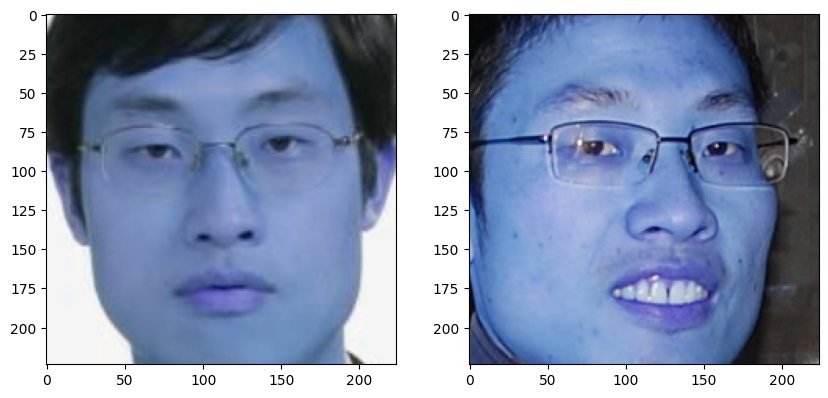

In [51]:
rimage=cv2.imread('data/trainset/0006/0006_0000557/0006_0000557_script.jpg')
image=cv2.imread('data/trainset/0006/0006_0000557/0000000.jpg')
rimg=image_resizing(rimage,path_haar)
img=image_resizing(image,path_haar)

fig=plt.figure(figsize=(10,10))
ax1 = fig.add_subplot(2,2,1)
ax1.imshow(rimg)
ax2 = fig.add_subplot(2,2,2)
ax2.imshow(img)

In [52]:
r_encode=encode_img(rimg,triplet_model)
img_encode=encode_img(img,triplet_model)
dist,conf=confidence_value(r_encode,img_encode)
if dist<threshold:
    print("Match with a confidence of ",conf*100)
    #print("Distance ",dist)
else:
    print("No Match with a confidence of ",abs(conf*100))

Match with a confidence of  100.0
